In [1]:
import os
import calendar
import plotly.offline as py
from ipywidgets import widgets
import plotly.graph_objs as go

from src.MyHomeEnergy import MyHomeEnergy
from src.PVWatts import PVWatts
from src.DataframeHelper import merge_dataframes, avg_month, annual_costs

import logging
logging.basicConfig(level=logging.INFO)

# Obtain most recent data
Authenticate to [My Home Energy](https://duke-energy.myhomeenergy.info) using the provided credentials, as well as [PVWatts](https://pvwatts.nrel.gov/pvwatts.php) to get the usable sunlight hours per month for the provided address.

Credentials are read from the [config.env](./credentials/config.env) file within this project.

In [2]:
try:
    filename = './credentials/config.env'
    deliminator = '='
    with open(filename, 'r') as f:
        for line in f.readlines():
            if line.startswith('#') or len(line.strip()) == 0:
                continue

            values = line.strip().split(deliminator)
            key = values[0].upper()
            value = deliminator.join(values[1:])
            if key not in os.environ:
                # only set environment variable if one isn't already set
                # this is useful when pointing to a different database server in debug mode
                os.environ.setdefault(key, value)
except FileNotFoundError:
    print('Unable to locate credentials filename!')
    exit(1)

In [3]:
m = MyHomeEnergy()
m.authenticate(os.environ['USERNAME'], os.environ['PASSWORD'])
df1 = m.to_dataframe()
del m

INFO:MyHomeEnergy:Using driver: /Users/szelenka/Documents/_svn/github/DukeEnergy/drivers/chromedriver
INFO:MyHomeEnergy:Downloading to: /Users/szelenka/Documents/_svn/github/DukeEnergy/data/raw


In [6]:
p = PVWatts(os.environ['STREET_ADDRESS'])
df2 = p.to_dataframe()
del p

INFO:PVWatts:Using driver: /Users/szelenka/Documents/_svn/github/DukeEnergy/drivers/chromedriver
INFO:PVWatts:Downloading to: /Users/szelenka/Documents/_svn/github/DukeEnergy/data/raw
INFO:PVWatts:Waiting for download to complete...,
INFO:PVWatts:Moving filename: /Users/szelenka/Documents/_svn/github/DukeEnergy/data/raw/pvwatts_monthly (2).csv -> /Users/szelenka/Documents/_svn/github/DukeEnergy/data/raw/pvwatts_monthly_20181206.csv


/Users/szelenka/Documents/_svn/github/DukeEnergy/data/raw/pvwatts_monthly (2).csv


In [7]:
df = merge_dataframes(df1, df2)

# Set initial Solar Array
To initialize the widget, we need to give it some reasonable metric to start from

In [8]:
initial_solar_kwh = 6
m = avg_month(df, initial_solar_kwh)
m.head()

,dollars,kwh,temp_avg,avg_cost_per_kwh,days,avg_kwh_per_day,avg_kw_per_hour,radiation_hours_per_day,kwh_demand,kwh_per_day_delta,kwh_per_month_delta
month_int,,,,,,,,,,,
6,153.041667,1472.666667,75.683333,0.103617,32.000000,46.247067,1.926961,6.489359,7.839260,11.204529,358.544936
7,170.283333,1643.166667,79.133333,0.103607,29.500000,55.641617,2.318401,6.226304,9.830195,22.019578,649.577543
8,162.495000,1561.166667,77.016667,0.103607,30.000000,51.921834,2.163410,5.856250,9.752661,20.298085,608.942549
9,142.713333,1374.166667,73.233333,0.103606,30.333333,45.523209,1.896800,5.383223,9.302147,16.453807,499.098818
10,84.025000,803.500000,63.066667,0.104106,30.333333,26.490685,1.103779,4.803068,6.066904,0.554117,16.808210


# Setup [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/stable/index.html)
Configure the widgets for live interactions.

In [9]:
w_kwh = widgets.FloatSlider(
    value=initial_solar_kwh,
    min=0.0,
    max=10.0,
    step=0.3, #300W pannel
    description='Solar kWh:',
    continous_update=False
)
w_price_per_watt = widgets.BoundedFloatText(
    value=3.12,
    min=0.,
    max=5.,
    step=.01,
    description='Price per watt',
    disabled=False
)
w_price_toggle = widgets.ToggleButtons(
    options=['$/Watt', 'Quote'],
    disabled=False,
    button_style=''
)
w_upfront_cost = widgets.FloatText(
    description='Upfront Cost:',
    value=round(initial_solar_kwh*1000*3.12, 2),
    disabled=True
)
w_ftc = widgets.Dropdown(
    options=[
        .3,
        .26,
        .1,
        0.
    ],
    value=.3,
    description='Federal Tax Credit:',
    disabled=False
)
w_duke_rebate = widgets.Dropdown(
    options=[
        .6,
        0.
    ],
    value=.6,
    description='Duke Rebate:',
    disabled=False
)
w_expense = widgets.Text(
    description='Annual Expense:',
    value='0.00',
    disabled=True
)
w_savings = widgets.Text(
    description='Annual Savings:',
    value='0.00',
    disabled=True
)
w_credits = widgets.Text(
    description='Unused Credits:',
    value='0.00',
    disabled=True
)
w_final_cost = widgets.Text(
    description='Final Cost:',
    value='0.00',
    disabled=True
)
w_roi_years = widgets.Text(
    description='Years to payoff:',
    value='0.00',
    disabled=True
)
container = widgets.VBox(
    children=[
        w_kwh,
        w_price_toggle,
        w_price_per_watt,
        w_upfront_cost,
        w_ftc,
        w_duke_rebate,
        w_final_cost,
        w_expense,
        w_savings,
        w_credits,
        w_roi_years
    ]
)
trace = go.Bar(
    x=[calendar.month_name[x] for x in m.index.tolist()],
    y=m['kwh_per_month_delta'].tolist()
)
fig = go.FigureWidget(
    data=[
        trace
    ],
    layout=go.Layout({
        'title': 'Solar Array Production',
        'barmode': 'overlay'
    })
)

def response(change):
    tmp = avg_month(df, solar_system_kwh=w_kwh.value)
    annual_expense, annual_credits, annual_savings = annual_costs(tmp)
    w_expense.value = '{:,.2f}'.format(annual_expense)
    w_savings.value = '{:,.2f}'.format(annual_savings)
    w_credits.value = '{:,.2f}'.format(annual_credits)
    update_cost(change)
    with fig.batch_update():
        fig.data[0].y = tmp['kwh_per_month_delta'].tolist()
        fig.layout.barmode = 'overlay'
        fig.layout.xaxis.title = 'Calendar Month'
        fig.layout.yaxis.title = 'kWh'
    
    
def update_cost(change):
    if w_price_toggle.value == 'Quote':
        w_price_per_watt.disabled = True
        w_upfront_cost.disabled = False
        total = w_upfront_cost.value
        w_price_per_watt.value = w_upfront_cost.value / (w_kwh.value * 1000)
    elif w_price_toggle.value == '$/Watt':
        w_upfront_cost.disabled = True
        w_price_per_watt.disabled = False
        total = round(w_price_per_watt.value * w_kwh.value * 1000, 2)
        w_upfront_cost.value = total#'{:,.2f}'.format(total)
        
    total = total * (1-w_ftc.value) - (w_kwh.value * 1000 * w_duke_rebate.value)
    w_final_cost.value = '{:,.2f}'.format(total)
    w_roi_years.value = '{:.2f}'.format(
        float(w_final_cost.value.replace(',', '')) / float(w_savings.value.replace(',', ''))
    )

    
w_price_toggle.observe(update_cost, names='value')
w_price_per_watt.observe(update_cost, names='value')
w_upfront_cost.observe(update_cost, names='value')
w_ftc.observe(update_cost, names='value')
w_duke_rebate.observe(update_cost, names='value')

w_kwh.observe(response, names='value')

# Launch the widget

In [10]:
widgets.HBox([
    fig,
    container,
])

    'data': [{'type': 'bar',
              'uid': '276b3f0c-f95a-11e8-94b3-ba002…

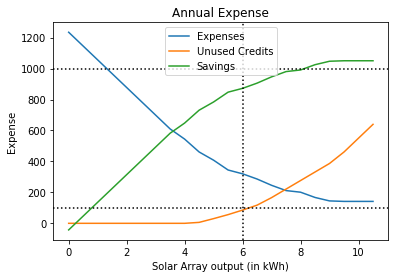

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
expenses = []
credits = []
savings = []
for initial_solar_kwh in np.arange(0, 11, .5):
    m = avg_month(df, initial_solar_kwh)
    annual_expense, annual_credits, annual_savings = annual_costs(m)
    expenses.append(annual_expense)
    credits.append(annual_credits)
    savings.append(annual_savings)
    
tmp = pd.DataFrame(list(zip(expenses, credits, savings)), index=np.arange(0, 11, .5))
tmp.columns = ['Expenses', 'Unused Credits', 'Savings']
ax = tmp.plot()
ax.set_title('Annual Expense')
ax.set_ylabel('Expense')
ax.set_xlabel('Solar Array output (in kWh)')
ax.axhline(y=100, color='k', linestyle=':')
ax.axhline(y=1000, color='k', linestyle=':')
ax.axvline(x=6, color='k', linestyle=':')
plt.show()

In [14]:
df[['date', 'avg_kwh_per_day']]

,date,avg_kwh_per_day
0,2012-12-01,23.066667
1,2013-01-01,22.448276
2,2013-02-01,22.357143
3,2013-03-01,20.724138
4,2013-04-01,22.441176
5,2013-05-01,25.206897
6,2013-06-01,38.030303
7,2013-07-01,51.214286
8,2013-08-01,47.678571
9,2013-09-01,43.400000
